In [ ]:
# --- 1. PERSIAPAN ---
!pip install lightgbm scikit-learn pandas -q

In [ ]:
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# --- 2. PROSES IMPORT DATA ---
try:
    df = pd.read_csv('data_sentimen_ml.csv')
    print("✅ File berhasil dimuat.")
except FileNotFoundError:
    print("❌ Error: File 'data_sentimen_ml.csv' tidak ditemukan.")
    exit()

df.dropna(subset=['clean_text'], inplace=True)
df['category'] = df['category'].astype(str)

✅ File berhasil dimuat.


In [ ]:
# --- 3. HAPUS KELAS LANGKA ---
class_counts = df['category'].value_counts()
classes_to_keep = class_counts[class_counts >= 2].index
df_filtered = df[df['category'].isin(classes_to_keep)]

In [ ]:
# --- 4. SIAPKAN DATA & FITUR ---
X = df_filtered['clean_text']
y = df_filtered['category']

print("⚙️  Melakukan vectorization pada teks...")
vectorizer = CountVectorizer(max_features=7000, ngram_range=(1, 2))
X_bow = vectorizer.fit_transform(X).astype('float')
print("✅ Vectorization selesai.")

⚙️  Melakukan vectorization pada teks...
✅ Vectorization selesai.


In [ ]:
# --- 5. LATIH & EVALUASI MODEL LIGHTGBM ---
X_train, X_test, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=42, stratify=y
)

print("⚙️  Melatih model LightGBM...")
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
print("✅ Model berhasil dilatih.")

y_pred = model.predict(X_test)

⚙️  Melatih model LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 21.999754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25543
[LightGBM] [Info] Number of data points in the train set: 159981, number of used features: 6986
[LightGBM] [Info] Start training from score -1.518993
[LightGBM] [Info] Start training from score -1.076909
[LightGBM] [Info] Start training from score -0.820024
✅ Model berhasil dilatih.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- HASIL EVALUASI MODEL LIGHTGBM ---
              precision    recall  f1-score   support

Negatif (-1)       0.92      0.79      0.85      8757
  Netral (0)       0.87      0.98      0.92     13624
 Positif (1)       0.94      0.91      0.92     17615

    accuracy                           0.91     39996
   macro avg       0.91      0.90      0.90     39996
weighted avg       0.91      0.91      0.91     39996


--- CONFUSION MATRIX ---


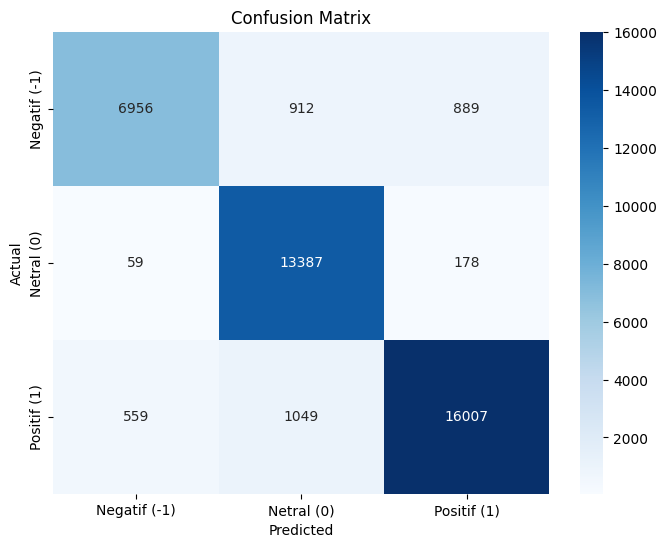

In [ ]:
# --- 6. HASIL EVALUASI LENGKAP ---

# Laporan Klasifikasi (Teks)
print("\n--- HASIL EVALUASI MODEL LIGHTGBM ---")
report = classification_report(y_test, y_pred, target_names=['Negatif (-1)', 'Netral (0)', 'Positif (1)'])
print(report)

# Confusion Matrix
print("\n--- CONFUSION MATRIX ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif (-1)', 'Netral (0)', 'Positif (1)'],
            yticklabels=['Negatif (-1)', 'Netral (0)', 'Positif (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


--- VISUALISASI METRIK KINERJA ---


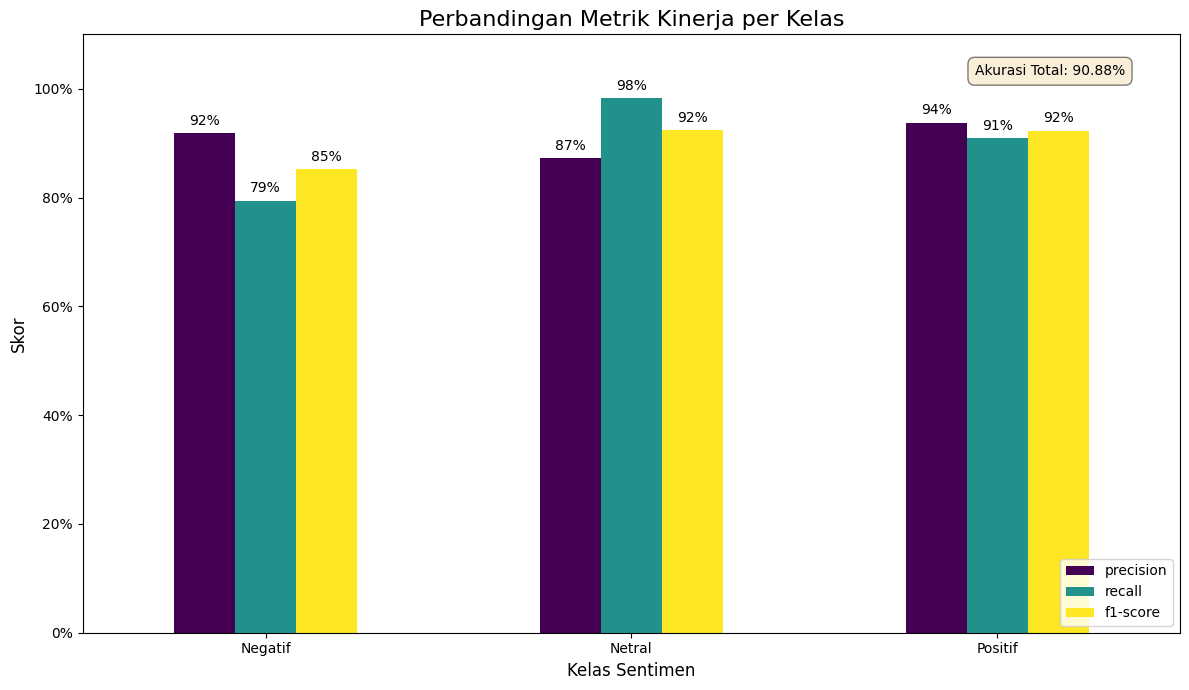

In [ ]:
# <<< BARU: Visualisasi Metrik Kinerja >>>
print("\n--- VISUALISASI METRIK KINERJA ---")
# Mendapatkan laporan dalam bentuk dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True)
# Mengambil data untuk kelas utama
metrics_df = pd.DataFrame({
    'Negatif': report_dict['-1'],
    'Netral': report_dict['0'],
    'Positif': report_dict['1']
}).transpose()

# Hanya mengambil presisi, recall, dan f1-score
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# Membuat plot
ax = metrics_df.plot(kind='bar', figsize=(12, 7), colormap='viridis', rot=0)
plt.title('Perbandingan Metrik Kinerja per Kelas', fontsize=16)
plt.ylabel('Skor', fontsize=12)
plt.xlabel('Kelas Sentimen', fontsize=12)
# Format sumbu Y menjadi persentase
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Menambahkan label persentase di atas setiap bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

# Menambahkan teks akurasi keseluruhan
accuracy = report_dict['accuracy']
plt.text(0.95, 0.95, f'Akurasi Total: {accuracy:.2%}', transform=ax.transAxes,
         horizontalalignment='right', verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

plt.ylim(0, 1.1) # Memberi ruang untuk label di atas bar
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# --- 7. PREDIKSI MENGGUNAKAN DATA BARU ---

# <<< BARU: Fungsi untuk prediksi data baru >>>
def prediksi_sentimen(teks_baru):
    # Ubah teks baru menjadi vektor menggunakan vectorizer yang sudah dilatih
    vektor_baru = vectorizer.transform(teks_baru).astype('float')

    # Lakukan prediksi
    prediksi = model.predict(vektor_baru)

    # Menampilkan hasil
    for teks, sentimen in zip(teks_baru, prediksi):
        if sentimen == '1':
            label = 'Positif'
        elif sentimen == '0':
            label = 'Netral'
        else:
            label = 'Negatif'
        print(f"Teks: '{teks}'\nPrediksi Sentimen: {label}\n")

# Contoh penggunaan fungsi
print("\n--- PREDIKSI PADA DATA BARU ---")
data_testing_baru = [
    "this movie was absolutely fantastic, I loved every minute of it!",
    "the service was terrible and the food was cold.",
    "it's an okay product, nothing special but it does the job.",
    "It's so bad"
]

prediksi_sentimen(data_testing_baru)


--- PREDIKSI PADA DATA BARU ---
Teks: 'this movie was absolutely fantastic, I loved every minute of it!'
Prediksi Sentimen: Positif

Teks: 'the service was terrible and the food was cold.'
Prediksi Sentimen: Negatif

Teks: 'it's an okay product, nothing special but it does the job.'
Prediksi Sentimen: Positif

Teks: 'It's so bad'
Prediksi Sentimen: Negatif

Teks: 'Sangat Buruk.'
Prediksi Sentimen: Netral

Teks: 'Bagus Sekali.'
Prediksi Sentimen: Netral



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
